In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext lab_black
# or nb_black

# Intro

# Imports and Data

In [3]:
import pandas as pd
from ecommercerecommendation.utils.data import get_data, bullet_points

In [4]:
df = get_data()
df["CustomerID"] = df["CustomerID"].astype(dtype=pd.Int64Dtype())

In [5]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  Int64         
 7   Country      541909 non-null  object        
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 33.6+ MB


# Exploratory analysis

In [7]:
print("Columns: " + bullet_points(df.columns))

Columns: 
- InvoiceNo
- StockCode
- Description
- Quantity
- InvoiceDate
- UnitPrice
- CustomerID
- Country


## Duplicates

In [8]:
(len(df) - len(df.drop_duplicates()))

5268

Having only this set of information, we are unable to decide whether these duplicates are effectively double purchases or errors in the system. Let us assume, for simplicity, that these are errors and let's get rid of those rows.

In [9]:
df = df.drop_duplicates()

In [10]:
((df.isna().sum() / len(df)) * 100).round(2).astype(str) + "%"

InvoiceNo        0.0%
StockCode        0.0%
Description     0.27%
Quantity         0.0%
InvoiceDate      0.0%
UnitPrice        0.0%
CustomerID     25.16%
Country          0.0%
dtype: object

Some description are missing and the CustomerID in 1/4 of the cases.

As Customer IDs are important for recommendation, 

In [11]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,536641.0,9.620029,-80995.0,1.0,3.0,10.0,80995.0,219.130156
InvoiceDate,536641,2011-07-04 08:57:06.087421952,2010-12-01 08:26:00,2011-03-28 10:52:00,2011-07-19 14:04:00,2011-10-18 17:05:00,2011-12-09 12:50:00,NaN
UnitPrice,536641.0,4.632656,-11062.06,1.25,2.08,4.13,38970.0,97.233118
CustomerID,401604.0,15281.160818,12346.0,13939.0,15145.0,16784.0,18287.0,1714.006089


In [12]:
df[df["Description"].isna()].head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,<NA>,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,<NA>,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,<NA>,United Kingdom


## Identifying CustomerIDs
Through other rows with the same invoice ID:

In [13]:
invoice_ids_no_customer_id = set(df[df["CustomerID"].isna()]["InvoiceNo"])

In [14]:
invoice_ids_yes_customer_id = set(df[~df["CustomerID"].isna()]["InvoiceNo"])

In [15]:
len(invoice_ids_no_customer_id)

3710

In [16]:
len(invoice_ids_yes_customer_id)

22190

In [17]:
len(invoice_ids_yes_customer_id & invoice_ids_no_customer_id)

0

It does not work. Let us remove all rows with missing values.

In [18]:
df = df.dropna(subset=["CustomerID", "Description"])

In [19]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [20]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,401604.0,12.183273,-80995.0,2.0,5.0,12.0,80995.0,250.283037
InvoiceDate,401604,2011-07-10 12:08:23.848567552,2010-12-01 08:26:00,2011-04-06 15:02:00,2011-07-29 15:40:00,2011-10-20 11:58:30,2011-12-09 12:50:00,NaN
UnitPrice,401604.0,3.474064,0.0,1.25,1.95,3.75,38970.0,69.764035
CustomerID,401604.0,15281.160818,12346.0,13939.0,15145.0,16784.0,18287.0,1714.006089


## Description spelling
There are some spaces at the beginning, at the end, in the middle, and some "+"s that we can get rid of:

In [21]:
df["Description"] = (
    df["Description"]
    .str.replace("+", " ")
    .str.strip()
    .apply(lambda s: " ".join(s.split()))
)

## Negative Quantities

<Axes: >

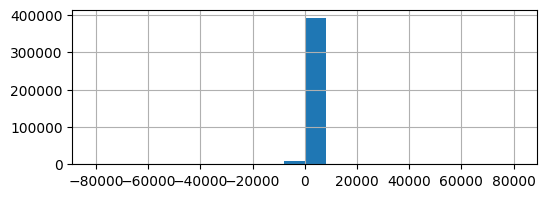

In [22]:
df["Quantity"].hist(bins=20, figsize=(6, 2))

In [23]:
((df["Quantity"].value_counts().head(10) / len(df)) * 100).round(2).astype(str) + "%"

Quantity
1     17.33%
12     14.9%
2      14.3%
6      9.33%
4      7.99%
3      6.68%
24      5.9%
10     5.27%
8      2.89%
5      2.02%
Name: count, dtype: object

Most quantities are what we expect to see.

In [24]:
print(df["Quantity"].value_counts().tail(10).to_string())

Quantity
 188      1
 588      1
-164      1
 430      1
 701      1
 828      1
 560      1
-408      1
 512      1
-80995    1


But there are some "strange", negative numbers.

In [25]:
df[df["Quantity"] > 0].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [26]:
df[df["Quantity"] < 0].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Negative quantities refer to cancelations and have the Invoice numbers starting with "C"

In [27]:
cancelled_InvoiceNo = set(df[df["Quantity"] < 0]["InvoiceNo"].apply(lambda x: x[1:]))

In [28]:
df[
    df["InvoiceNo"].isin(cancelled_InvoiceNo)
]  # => they do not have a corresponding invoice number without a "C"

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


### Checking cancelations of one Customer

In [29]:
df[df["CustomerID"] == 17548].drop(columns=["CustomerID", "Country"])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65
165024,550755,22585,PACK OF 6 BIRDY GIFT TAGS,24,2011-04-20 12:01:00,1.25
165025,550755,22082,RIBBON REEL STRIPES DESIGN,10,2011-04-20 12:01:00,1.65
165026,550755,22081,RIBBON REEL FLORA FAUNA,10,2011-04-20 12:01:00,1.65


In [30]:
for n, row in df[(df["Quantity"] < 0) & (df["CustomerID"] == 17548)].iterrows():
    print(
        len(
            df[
                (df["Quantity"] == -row["Quantity"])
                & (df["StockCode"] == row["StockCode"])
                & (df["Description"] == row["Description"])
                & (df["UnitPrice"] == row["UnitPrice"])
                & (df["CustomerID"] == row["CustomerID"])
            ]
        )
    )

0
0
0
0
0
0
0
1
1
1
1
1


For simplicity, let us get rid of those lines where we find both the order and the cancelations, and the all the cancelations, keeping only positive orders.

In [31]:
remove_indices = []

for n, row in df[(df["Quantity"] < 0)].iterrows():
    found_df = df[
        (df["Quantity"] == -row["Quantity"])
        & (df["StockCode"] == row["StockCode"])
        & (df["Description"] == row["Description"])
        & (df["UnitPrice"] == row["UnitPrice"])
        & (df["CustomerID"] == row["CustomerID"])
    ]
    if len(found_df) == 1:
        remove_indices = remove_indices + list(found_df.index)
    remove_indices.append(n)

In [32]:
len(remove_indices) / len(df)

0.02739265545163893

In [33]:
df = df[~df.index.isin(remove_indices)]

## Saving/loading data checkpoint

In [34]:
df.to_csv("cache/cleaner_data.csv", index=False, encoding="utf-8")

In [35]:
df = get_data("cleaner_data")

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390671 entries, 0 to 390670
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    390671 non-null  int64         
 1   StockCode    390671 non-null  object        
 2   Description  390671 non-null  object        
 3   Quantity     390671 non-null  int64         
 4   InvoiceDate  390671 non-null  datetime64[ns]
 5   UnitPrice    390671 non-null  float64       
 6   CustomerID   390671 non-null  int64         
 7   Country      390671 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 23.8+ MB


## Some stats

<Axes: >

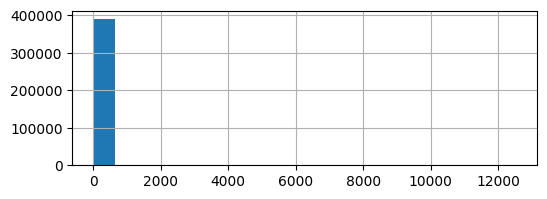

In [37]:
df["Quantity"].hist(bins=20, figsize=(6, 2))

<Axes: >

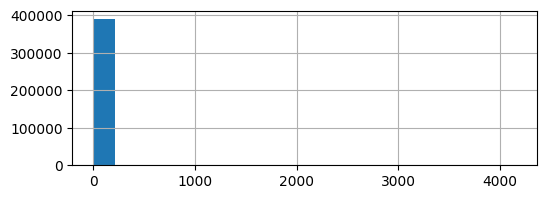

In [38]:
df["UnitPrice"].hist(bins=20, figsize=(6, 2))

In [39]:
df[["Quantity", "UnitPrice"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,390671.0,12.716083,47.160308,1.0,2.00,6.00,12.00,12540.00
UnitPrice,390671.0,3.032133,14.493934,0.0,1.25,1.95,3.75,4161.06


Let us get rid of those transactions with UnitPrice == 0

In [40]:
df = df[df["UnitPrice"] > 0]

In [41]:
df[df["Quantity"] >= df["Quantity"].quantile(0.99)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
96,536378,21212,PACK OF 72 RETROSPOT CAKE CASES,120,2010-12-01 09:37:00,0.42,14688,United Kingdom
176,536387,79321,CHILLI LIGHTS,192,2010-12-01 09:58:00,3.82,16029,United Kingdom
177,536387,22780,LIGHT GARLAND BUTTERFILES PINK,192,2010-12-01 09:58:00,3.37,16029,United Kingdom
178,536387,22779,WOODEN OWLS LIGHT GARLAND,192,2010-12-01 09:58:00,3.37,16029,United Kingdom
179,536387,22466,FAIRY TALE COTTAGE NIGHTLIGHT,432,2010-12-01 09:58:00,1.45,16029,United Kingdom
...,...,...,...,...,...,...,...,...
390135,581476,72232,FENG SHUI PILLAR CANDLE,144,2011-12-09 08:48:00,0.19,12433,Norway
390225,581487,21137,BLACK RECORD COVER FRAME,120,2011-12-09 09:44:00,3.39,15694,United Kingdom
390317,581501,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,180,2011-12-09 10:46:00,0.19,12985,United Kingdom
390467,581566,23404,HOME SWEET HOME BLACKBOARD,144,2011-12-09 11:50:00,3.26,18102,United Kingdom


Let us keep them for now.

## StockCode

In [42]:
df["StockCode"].head(5)

0    85123A
1     71053
2    84406B
3    84029G
4    84029E
Name: StockCode, dtype: object

In [43]:
for code in ["85123A", "84406B", "84029G", "84029E"]:
    print(code, df[df["StockCode"].str.startswith("85123")]["StockCode"].nunique())

85123A 1
84406B 1
84029G 1
84029E 1


It seems that they have a letter at the end, but we don't have a corresponding code without the letter.

In [44]:
sorted(df[~df["StockCode"].str.isnumeric()]["StockCode"].unique())[-10:]

['90214V',
 '90214W',
 '90214Y',
 '90214Z',
 'BANK CHARGES',
 'C2',
 'DOT',
 'M',
 'PADS',
 'POST']

In [45]:
non_code_codes = ["BANK CHARGES", "C2", "DOT", "M", "PADS", "POST"]

In [46]:
df[df["StockCode"].isin(non_code_codes)]["Description"].unique()

array(['POSTAGE', 'CARRIAGE', 'Manual', 'Bank Charges',
       'PADS TO MATCH ALL CUSHIONS', 'DOTCOM POSTAGE'], dtype=object)

These seem to be different things, not products, let us get rid of them:

In [47]:
df = df[~df["StockCode"].isin(non_code_codes)]

In [48]:
alphanumeric_codes = df[~df["StockCode"].str.isnumeric()]["StockCode"].unique()

In [49]:
numeric_codes_from_alphanumeric = {code[:-1] for code in alphanumeric_codes}

In [50]:
numeric_codes = set(df[df["StockCode"].str.isnumeric()]["StockCode"].unique())

In [51]:
numeric_codes & numeric_codes_from_alphanumeric

{'47566'}

There is only one number that is present in both sets: 47566

In [52]:
df[df["StockCode"].str.startswith("47566")][
    [
        "StockCode",
        "Description",  # plus: "UnitPrice", "Country", but they do not add additional info
    ]
].drop_duplicates()

,StockCode,Description
2388,47566B,TEA TIME PARTY BUNTING
4289,47566,PARTY BUNTING


Let us consider them the same, and at the same time, let us drop all letters to have a unified StockCode. All other numbers are 5 digit long already:

In [53]:
df[df["StockCode"].str.isnumeric()]["StockCode"].apply(len).unique()

array([5])

In [54]:
df["StockCode"] = df["StockCode"].apply(lambda s: s[:5]).astype(int)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 389134 entries, 0 to 390670
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    389134 non-null  int64         
 1   StockCode    389134 non-null  int64         
 2   Description  389134 non-null  object        
 3   Quantity     389134 non-null  int64         
 4   InvoiceDate  389134 non-null  datetime64[ns]
 5   UnitPrice    389134 non-null  float64       
 6   CustomerID   389134 non-null  int64         
 7   Country      389134 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 26.7+ MB


## Description

In [56]:
(
    df.groupby("StockCode")["Description"].nunique().value_counts()
    / df["StockCode"].nunique()
    * 100
).round(2).astype(str) + "%"

Description
1     86.06%
2      9.86%
3      2.45%
4      1.04%
5      0.25%
6      0.25%
8      0.06%
24     0.03%
Name: count, dtype: object

Most of the StockCodes have 1 descripition.

In [57]:
stockcodes_many_descriptions = list(
    df.groupby("StockCode")["Description"]
    .nunique()[df.groupby("StockCode")["Description"].nunique() > 2]
    .index
)

In [58]:
df[df["StockCode"].isin(stockcodes_many_descriptions)].sort_values(
    by="StockCode"
).groupby("StockCode")["Description"].unique().to_list()[:10]

[array(['PINK PAPER PARASOL', 'RED PAPER PARASOL', 'BLUE PAPER PARASOL',
        'PURPLE PAPER PARASOL'], dtype=object),
 array(['EDWARDIAN PARASOL BLACK', 'EDWARDIAN PARASOL NATURAL',
        'EDWARDIAN PARASOL PINK'], dtype=object),
 array(['BLUE POLKADOT GARDEN PARASOL', 'PINK POLKADOT GARDEN PARASOL',
        'ICE CREAM DESIGN GARDEN PARASOL'], dtype=object),
 array(['WRAP PINK FAIRY CAKES', 'WRAP CAROUSEL', 'WRAP, CAROUSEL'],
       dtype=object),
 array(['WRAP BAD HAIR DAY', 'WRAP SUKI AND FRIENDS', 'WRAP ENGLISH ROSE',
        'WRAP PINK FLOCK'], dtype=object),
 array(["WRAP 50'S CHRISTMAS", 'WRAP DAISY CARPET', 'WRAP FOLK ART',
        'WRAP BLUE RUSSIAN FOLKART', 'WRAP GREEN RUSSIAN FOLKART'],
       dtype=object),
 array(['PASTEL PINK PHOTO ALBUM', 'BLACK PHOTO ALBUM',
        'PASTEL BLUE PHOTO ALBUM'], dtype=object),
 array(['ORIGAMI SANDLEWOOD INCENSE/CAND SET',
        'ORIGAMI LAVENDER INCENSE/CANDL SET',
        'ORIGAMI VANILLA INCENSE/CANDLE SET',
        'ORIGAMI ROS

They seem to be variations of the similar products. Can help when we use text data/LLM. All of them are upper case?

In [59]:
sorted(df[df["Description"].str.upper() != df["Description"]]["Description"].unique())

['3 TRADITIONAl BISCUIT CUTTERS SET',
 'BAG 125g SWIRLY MARBLES',
 'BAG 250g SWIRLY MARBLES',
 'BAG 500g SWIRLY MARBLES',
 'ESSENTIAL BALM 3.5g TIN IN ENVELOPE',
 'FLOWERS HANDBAG blue and orange',
 'FOLK ART GREETING CARD,pack/12',
 'FRENCH BLUE METAL DOOR SIGN No',
 'High Resolution Image',
 'NUMBER TILE COTTAGE GARDEN No',
 'NUMBER TILE VINTAGE FONT No',
 'Next Day Carriage',
 'POLYESTER FILLER PAD 30CMx30CM',
 'POLYESTER FILLER PAD 40x40cm',
 'POLYESTER FILLER PAD 45x30cm',
 'POLYESTER FILLER PAD 45x45cm',
 'POLYESTER FILLER PAD 60x40cm',
 'POLYESTER FILLER PAD 65CMx65CM',
 'THE KING GIFT BAG 25x24x12cm']

In [60]:
non_description = ["High Resolution Image", "Next Day Carriage"]

In [61]:
df[df["Description"].isin(non_description)].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
140344,554835,23444,Next Day Carriage,1,2011-05-26 16:11:00,15.0,15241,United Kingdom
143405,555251,23444,Next Day Carriage,1,2011-06-01 15:12:00,15.0,13062,United Kingdom
143762,555312,23444,Next Day Carriage,1,2011-06-02 10:39:00,15.0,16484,United Kingdom
144079,555367,23444,Next Day Carriage,1,2011-06-02 14:28:00,15.0,17900,United Kingdom
149511,555948,23444,Next Day Carriage,1,2011-06-08 10:49:00,30.0,13752,United Kingdom
154390,556574,23444,Next Day Carriage,1,2011-06-13 13:41:00,15.0,16209,United Kingdom
155330,556767,23444,Next Day Carriage,1,2011-06-14 12:17:00,15.0,18073,United Kingdom
155776,556794,23444,Next Day Carriage,1,2011-06-14 14:06:00,15.0,13720,United Kingdom
162613,557681,23444,Next Day Carriage,1,2011-06-22 10:31:00,15.0,14463,United Kingdom
167015,558233,23444,Next Day Carriage,1,2011-06-27 14:36:00,15.0,18073,United Kingdom


In [62]:
df[df["Description"].isin(non_description)]["StockCode"].unique()

array([23444, 23702])

Probably they are not products, let us get rid of them, too:

In [63]:
df = df[~df["Description"].isin(non_description)]

## Saving/loading data checkpoint 2

In [64]:
df.to_csv("cache/clean_data.csv", index=False, encoding="utf-8")